In [2]:
from importlib.metadata import version

print("torch version:", version("torch"))

torch version: 2.1.1


In [3]:
import torch

inputs = torch.tensor(
  [[0.43, 0.15, 0.89], # Your     (x^1)
   [0.55, 0.87, 0.66], # journey  (x^2)
   [0.57, 0.85, 0.64], # starts   (x^3)
   [0.22, 0.58, 0.33], # with     (x^4)
   [0.77, 0.25, 0.10], # one      (x^5)
   [0.05, 0.80, 0.55]] # step     (x^6)
)

## basically A.A(T) krr rhe wrt 2nd input token

In [4]:
query = inputs[1]

attn_scores_2 = torch.empty(inputs.shape[0])

for i, x_i in enumerate(inputs):

    attn_scores_2[i] = torch.dot(x_i, query)

print(attn_scores_2)

tensor([0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865])


* Step 2: normalize the unnormalized attention scores ("omegas", 
) so that they sum up to 1
* Here is a simple way to normalize the unnormalized attention scores to sum up to 1 (a convention, useful for interpretation, and important for training stability):

In [5]:
attn_scores_2_tmp = attn_scores_2 / attn_scores_2.sum()
print(attn_scores_2_tmp)

tensor([0.1455, 0.2278, 0.2249, 0.1285, 0.1077, 0.1656])



* However, in practice, using the softmax function for normalization, which is better at handling extreme values and has more desirable gradient properties during training, is common and recommended.
* Here's a naive implementation of a softmax function for scaling, which also normalizes the vector elements such that they sum up to 1:

In [6]:
def softmax_naive(x):
    return torch.exp(x) / torch.exp(x).sum(dim=0)

attn_weights_2_naive = softmax_naive(attn_scores_2)

print(attn_weights_2_naive)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])



* The naive implementation above can suffer from numerical instability issues for large or small input values due to overflow and underflow issues
* Hence, in practice, it's recommended to use the PyTorch implementation of softmax instead, which has been highly optimized for performance:

In [7]:
attn_weights_2 = torch.softmax(attn_scores_2, dim=0)

print(attn_weights_2)

tensor([0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581])


* Step 3: compute the context vector Z(2) by multiplying the embedded input tokens, X(i) with the attention weights and sum the resulting vectors:

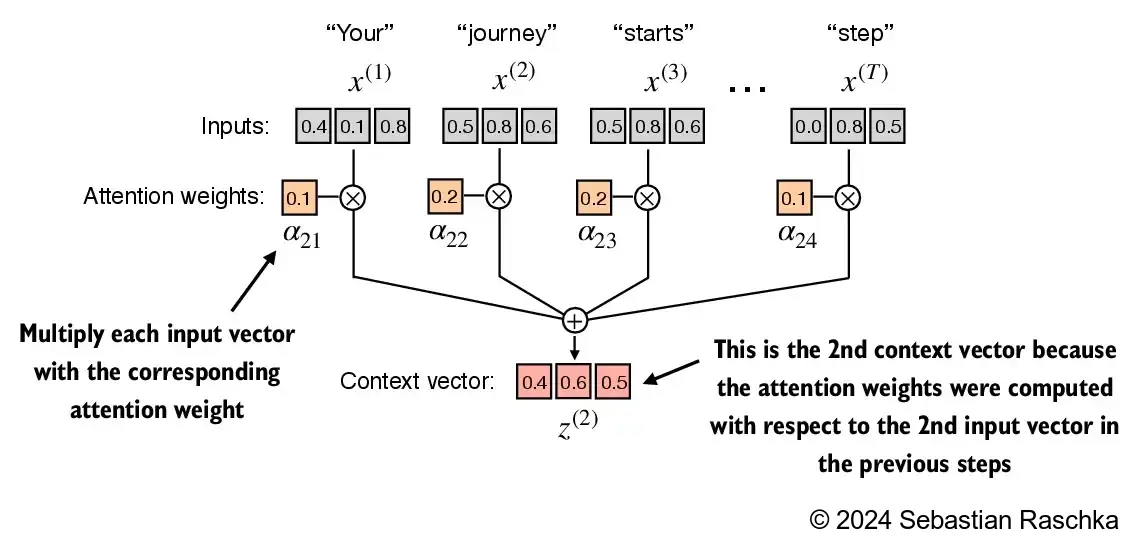

In [8]:

query = inputs[1] # 2nd input token is the query

context_vec_2 = torch.zeros(query.shape)
temp=0
print(context_vec_2)
for i,x_i in enumerate(inputs):
    context_vec_2 += attn_weights_2[i]*x_i
    print(context_vec_2)


print(context_vec_2)

tensor([0., 0., 0.])
tensor([0.0596, 0.0208, 0.1233])
tensor([0.1904, 0.2277, 0.2803])
tensor([0.3234, 0.4260, 0.4296])
tensor([0.3507, 0.4979, 0.4705])
tensor([0.4340, 0.5250, 0.4813])
tensor([0.4419, 0.6515, 0.5683])
tensor([0.4419, 0.6515, 0.5683])


# 3.3.2 Computing attention weights for all input tokens


#### Generalize to all input sequence tokens:

* Above, we computed the attention weights and context vector for input 2 (as illustrated in the highlighted row in the figure below)
* Next, we are generalizing this computation to compute all attention weights and context vectors

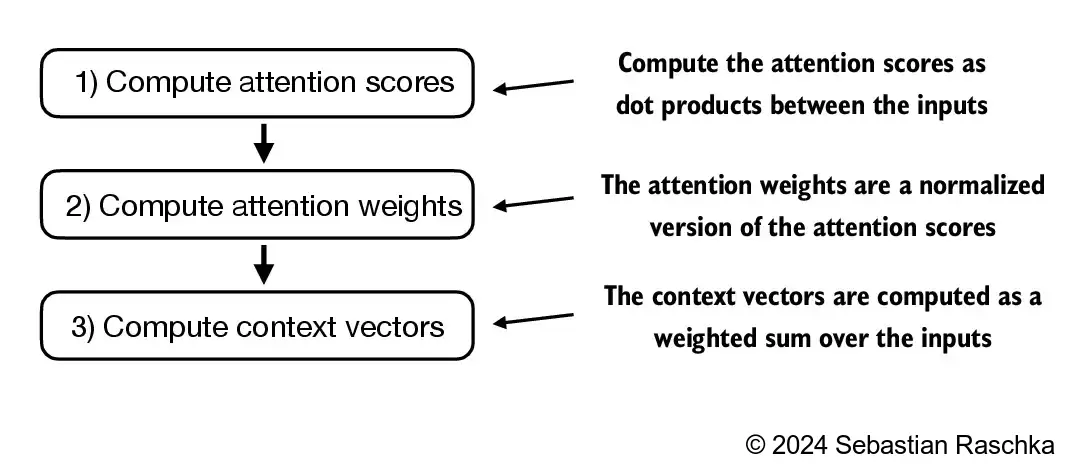

In [9]:
attn_scores = torch.empty(6,6)

for i, x_i in enumerate(inputs):
    for j, j_i in enumerate(inputs):
        attn_scores[i, j] = torch.dot(x_i, j_i)

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [10]:
type(attn_scores)

torch.Tensor

* We can achieve the same as above more efficiently via matrix multiplication:

In [11]:
attn_scores = inputs @ inputs.T

print(attn_scores)

tensor([[0.9995, 0.9544, 0.9422, 0.4753, 0.4576, 0.6310],
        [0.9544, 1.4950, 1.4754, 0.8434, 0.7070, 1.0865],
        [0.9422, 1.4754, 1.4570, 0.8296, 0.7154, 1.0605],
        [0.4753, 0.8434, 0.8296, 0.4937, 0.3474, 0.6565],
        [0.4576, 0.7070, 0.7154, 0.3474, 0.6654, 0.2935],
        [0.6310, 1.0865, 1.0605, 0.6565, 0.2935, 0.9450]])


In [12]:
attn_weights = torch.softmax(attn_scores, dim = -1)
print(attn_weights)

tensor([[0.2098, 0.2006, 0.1981, 0.1242, 0.1220, 0.1452],
        [0.1385, 0.2379, 0.2333, 0.1240, 0.1082, 0.1581],
        [0.1390, 0.2369, 0.2326, 0.1242, 0.1108, 0.1565],
        [0.1435, 0.2074, 0.2046, 0.1462, 0.1263, 0.1720],
        [0.1526, 0.1958, 0.1975, 0.1367, 0.1879, 0.1295],
        [0.1385, 0.2184, 0.2128, 0.1420, 0.0988, 0.1896]])


In [13]:
all_context_vecs = attn_weights @ inputs

print(all_context_vecs)

tensor([[0.4421, 0.5931, 0.5790],
        [0.4419, 0.6515, 0.5683],
        [0.4431, 0.6496, 0.5671],
        [0.4304, 0.6298, 0.5510],
        [0.4671, 0.5910, 0.5266],
        [0.4177, 0.6503, 0.5645]])


#  3.4 Implementing self-attention with trainable weights

* A conceptual framework illustrating how the self-attention mechanism developed in this section integrates into the overall narrative and structure of this book and chapte


* In this section, we are implementing the self-attention mechanism that is used in the original transformer architecture, the GPT models, and most other popular LLMs
* This self-attention mechanism is also called "scaled dot-product attention"
* The overall idea is similar to before:
  * We want to compute context vectors as weighted sums over the    input vectors specific to a certain input element
  * For the above, we need attention weights
* As you will see, there are only slight differences compared to the basic attention mechanism introduced earlier:
  * The most notable difference is the introduction of weight matrices that are updated during model training
  * These trainable weight matrices are crucial so that the model (specifically, the attention module inside the model) can learn to produce "good" context vectors

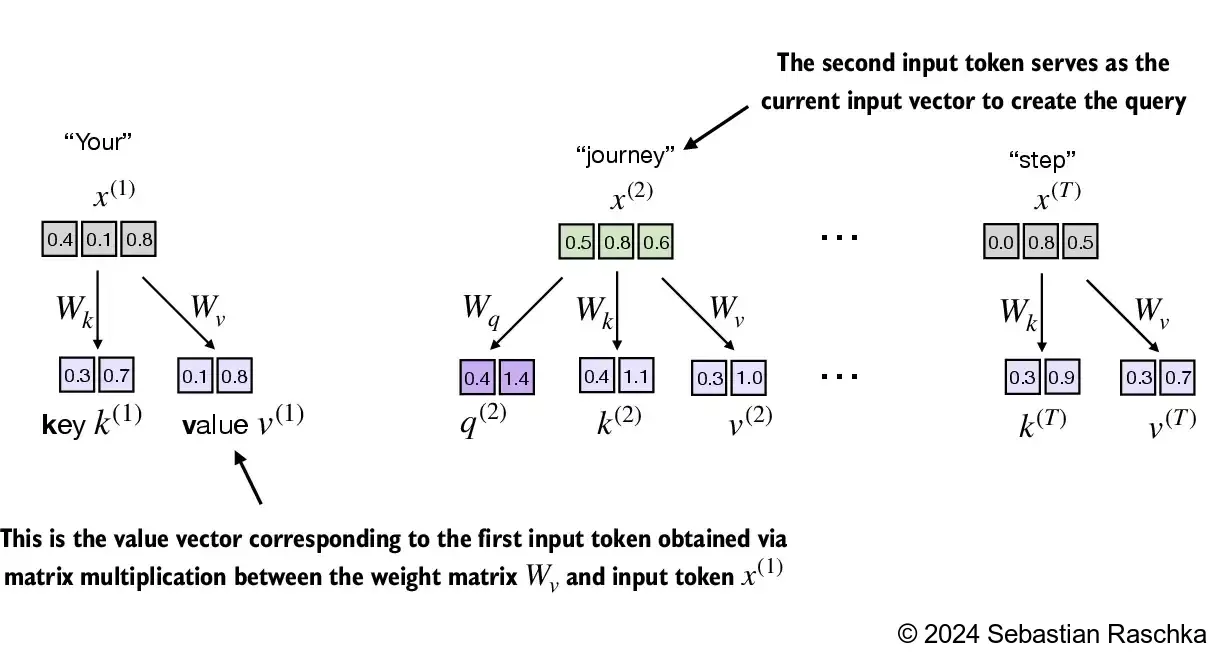

* Implementing the self-attention mechanism step by step, we will start by introducing the three training weight matrices $W_q$, $W_k$, and $W_v$\n",

* These three matrices are used to project the embedded input tokens, $x^{(i)}$, into query, key, and value vectors via matrix multiplication:\n",
    "\n",
    * Query vector: $q^{(i)} = W_q \\,x^{(i)}$\n",
    * Key vector: $k^{(i)} = W_k \\,x^{(i)}$\n",
    * Value vector: $v^{(i)} = W_v \\,x^{(i)}$\n"


* The embedding dimensions of the input x and the query vector r can be the same or different, depending on the model's design and specific implementation
 
* In GPT models, the input and output dimensions are usually the same, but for illustration purposes, to better follow the computation, we choose different input and output dimensions here:

In [14]:
x_2 = inputs[1]
d_in = inputs.shape[1]
d_out = 2

In [15]:
print(d_in)

3


* Below, we initialize the three weight matrices; note that we are setting requires_grad=False to reduce clutter in the outputs for illustration purposes, but if we were to use the weight matrices for model training, we would set requires_grad=True to update these matrices during model training

In [16]:
torch.manual_seed(123)

w_query = torch.nn.Parameter(torch.rand((d_in, d_out)), requires_grad=False)
w_key = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)
w_value = torch.nn.Parameter(torch.rand(d_in, d_out), requires_grad=False)

* Next we compute the query, key, and value vectors:

In [17]:
query_2 = x_2 @ w_query
key_2 = x_2 @ w_key
value_2 = x_2 @ w_value

In [18]:
print(query_2)

tensor([0.4306, 1.4551])



* As we can see below, we successfully projected the 6 input tokens from a 3D onto a 2D embedding space:

In [19]:
keys = inputs @ w_key
values = inputs @ w_value

* In the next step, step 2, we compute the unnormalized attention scores by computing the dot product between the query and each key vector:

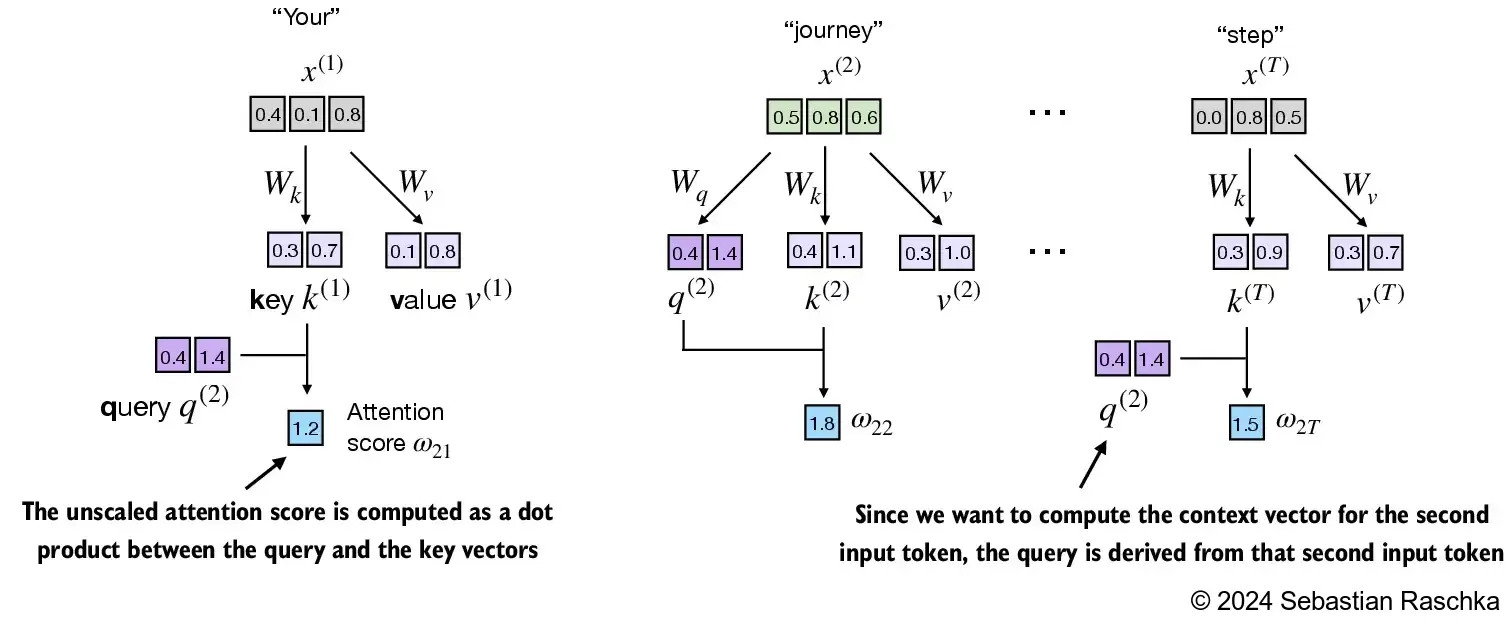

In [20]:
keys_2 = keys[1]
attn_score_22 = query_2.dot(keys_2)
print(attn_score_22)

tensor(1.8524)


* since we have 6 inputs, we have 6 attention scoers for the given vector:

In [21]:
attn_scores_2 = query_2 @ keys.T

In [22]:
print(attn_scores_2)

tensor([1.2705, 1.8524, 1.8111, 1.0795, 0.5577, 1.5440])


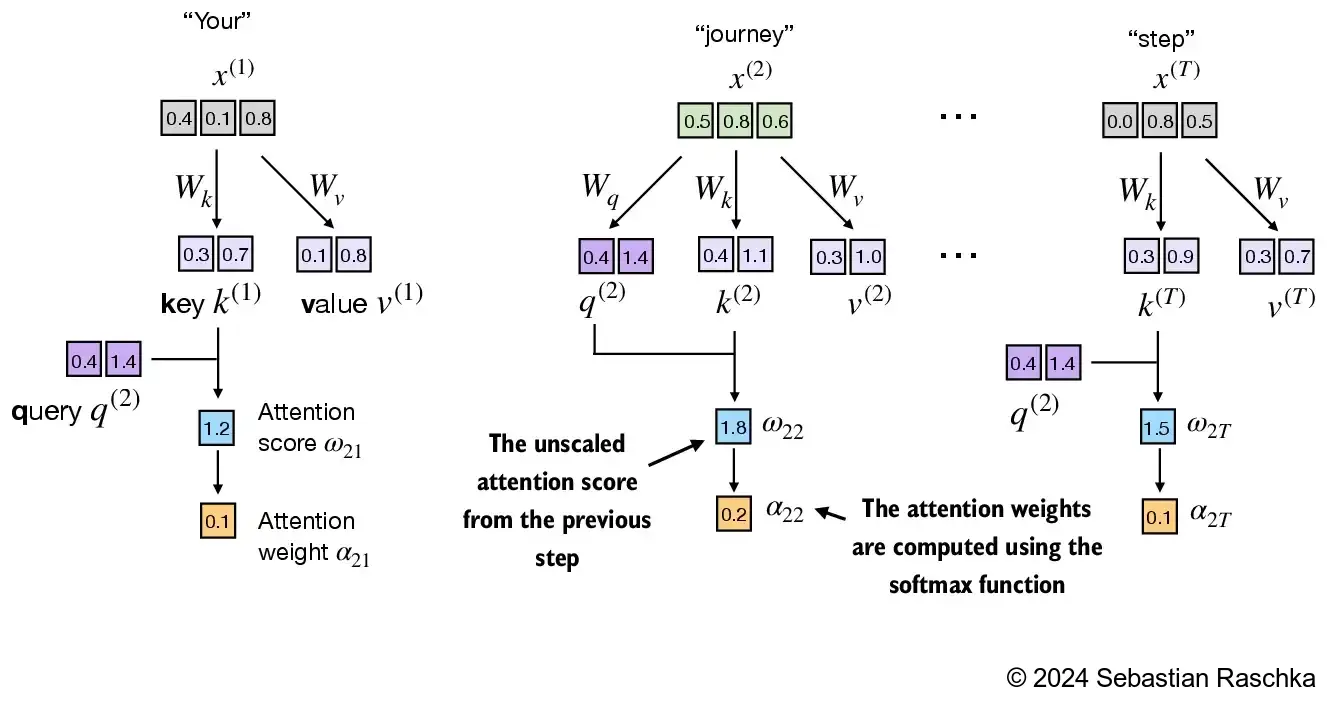


* Next, in step 3, we compute the attention weights (normalized attention scores that sum up to 1) using the softmax function we used earlier
* The difference to earlier is that we now scale the attention scores by dividing them by the square root of the embedding dimension, 
 (i.e., d_k**0.5):

In [23]:
d_k = keys.shape[1]
attn_weights_2 = torch.softmax(attn_scores_2 / d_k**0.5, dim=-1)
print(attn_weights_2)

tensor([0.1500, 0.2264, 0.2199, 0.1311, 0.0906, 0.1820])


* in step 4, we onw compute the context vector for the input query vector 2:

In [24]:
context_vec_2 = attn_weights_2 @ values
print(context_vec_2)

tensor([0.3061, 0.8210])


## 3.4.2 Implementing a compact SelfAttention class

In [25]:
import torch.nn as nn 

class selfAttention_v1(nn.Module):

    def __init__(self, d_in, d_out):
        super().__init__()
        self.w_query = nn.Parameter(torch.rand(d_in, d_out))
        self.w_value = nn.Parameter(torch.rand(d_in, d_out))
        self.w_key = nn.Parameter(torch.rand(d_in, d_out))

    def forward(self, x):
        keys = x @ self.w_key
        values = x @ self.w_value
        queries = x @ self.w_query 

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim = -1)

        context_vec = attn_weights @ values
        return context_vec
    
torch.manual_seed(123)
sa_v1 = selfAttention_v1(d_in, d_out)
print(sa_v1(inputs))


tensor([[0.3507, 0.8808],
        [0.3566, 0.8973],
        [0.3563, 0.8966],
        [0.3464, 0.8692],
        [0.3446, 0.8644],
        [0.3502, 0.8795]], grad_fn=<MmBackward0>)


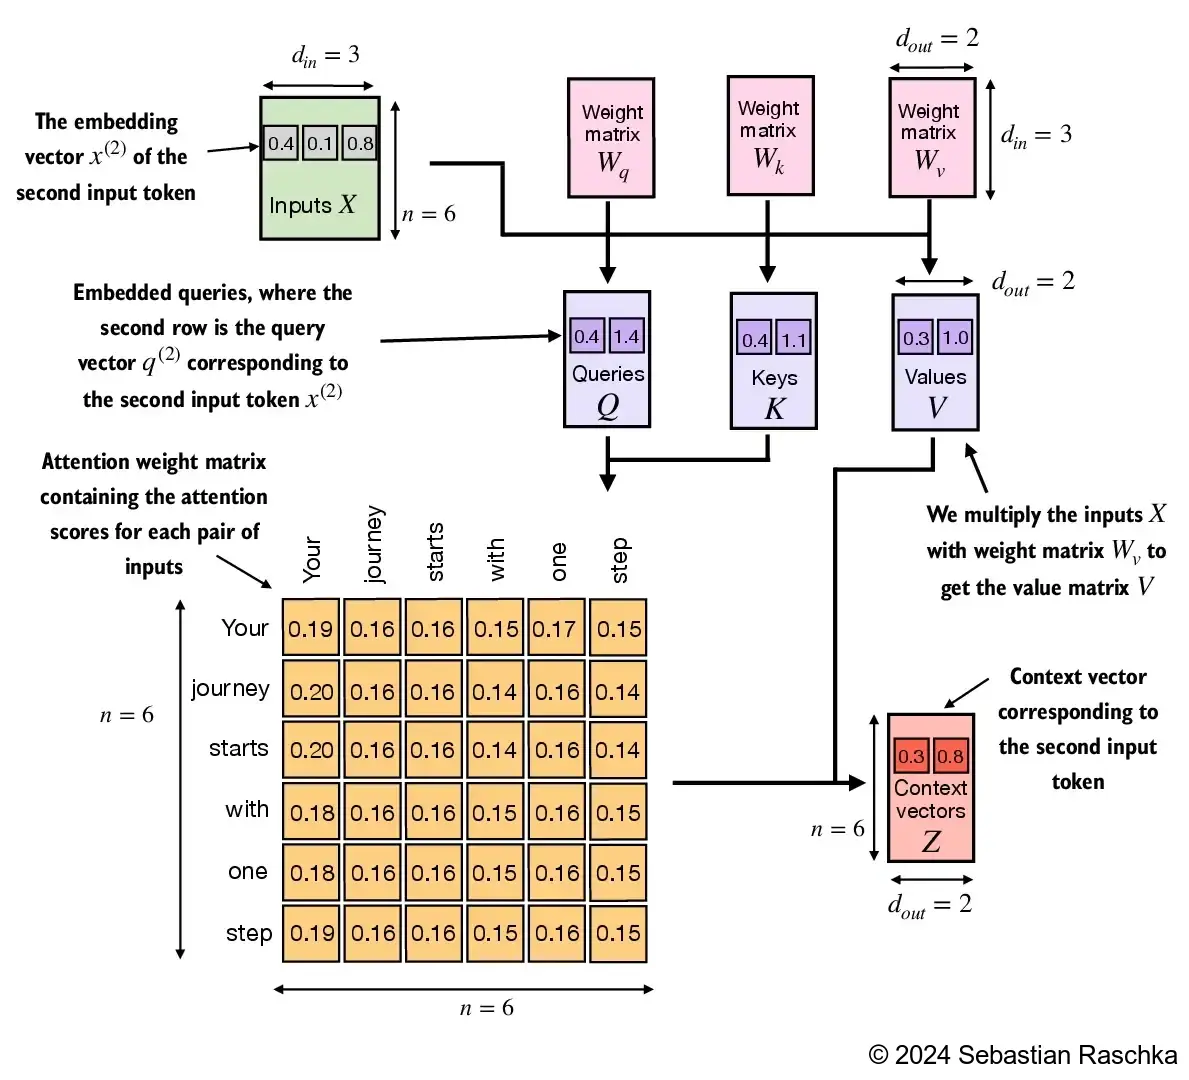

* We can streamline the implementation above using PyTorch's Linear layers, which are equivalent to a matrix multiplication if we disable the bias units
* Another big advantage of using nn.Linear over our manual nn.Parameter(torch.rand(...) approach is that nn.Linear has a preferred weight initialization scheme, which leads to more stable model training

In [26]:
class selfattention_v2(nn.Module):

    def __init__(self, d_in, d_out, qkv_bias=False):
        super().__init__()
        self.w_query = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias = qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias = qkv_bias)

    def forward(self, x):
        keys = self.w_key(x)
        values = self.w_value(x)
        queries = self.w_query(x)

        attn_scores = queries @ keys.T
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

        context_vec = attn_weights @ values
        return context_vec
    
torch.manual_seed(123)
sa_v2 = selfattention_v2(d_in, d_out)
print(sa_v2(inputs))

tensor([[-0.5337, -0.1051],
        [-0.5323, -0.1080],
        [-0.5323, -0.1079],
        [-0.5297, -0.1076],
        [-0.5311, -0.1066],
        [-0.5299, -0.1081]], grad_fn=<MmBackward0>)


Note that SelfAttention_v1 and SelfAttention_v2 give different outputs because they use different initial weights for the weight matrices


## 3.5 Hiding future words with causal attention

* In causal attention, the attention weights above the diagonal are masked, ensuring that for any given input, the LLM is unable to utilize future tokens while calculating the context vectors with the attention weight

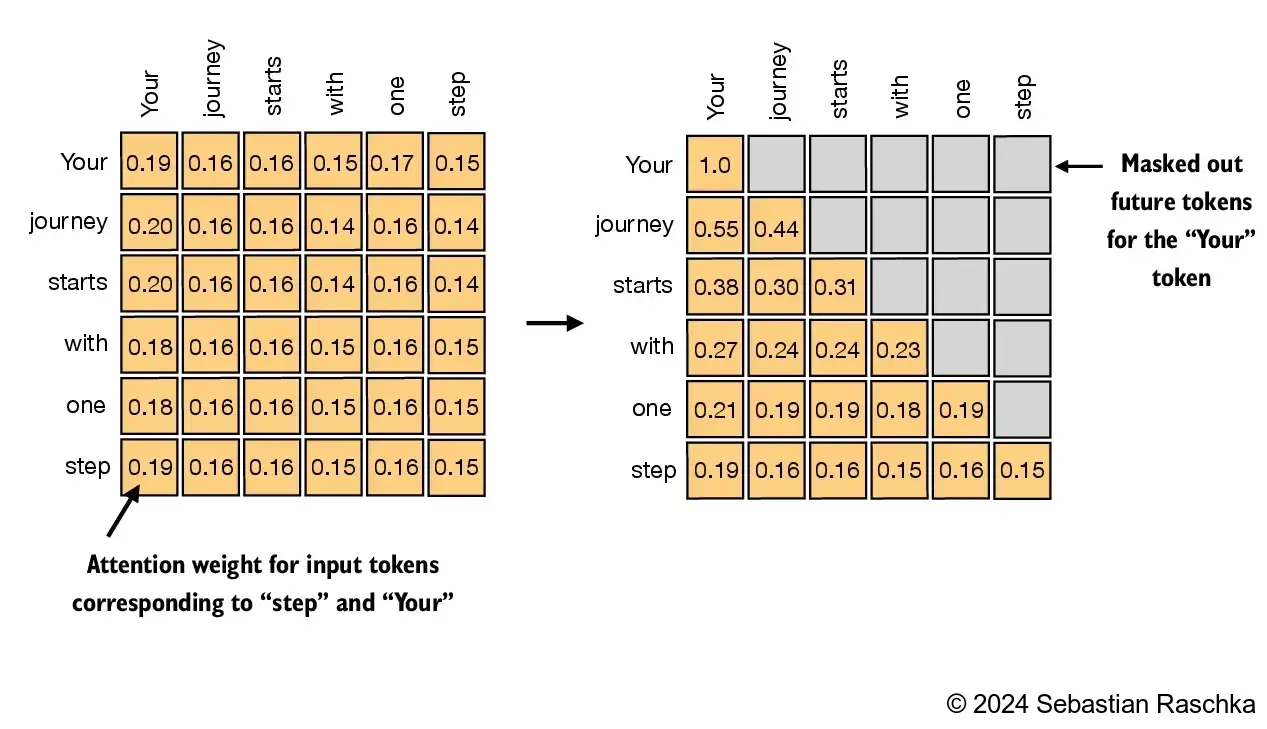

* In this section, we are converting the previous self-attention mechanism into a causal self-attention mechanism

* Causal self-attention ensures that the model's prediction for a certain position in a sequence is only dependent on the known outputs at previous positions, not on future positions

* In simpler words, this ensures that each next word prediction should only depend on the preceding words

* To achieve this, for each given token, we mask out the future tokens (the ones that come after the current token in the input text):

* To illustrate and implement causal self-attention, let's work with the attention scores and weights from the previous section:

In [27]:
keys = sa_v2.w_key(inputs)
queries = sa_v2.w_query(inputs)

attn_scores = queries @ keys.T
attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)

print(attn_weights)

tensor([[0.1717, 0.1762, 0.1761, 0.1555, 0.1627, 0.1579],
        [0.1636, 0.1749, 0.1746, 0.1612, 0.1605, 0.1652],
        [0.1637, 0.1749, 0.1746, 0.1611, 0.1606, 0.1651],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.1632, 0.1674],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.1639],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


In [28]:
context_length = attn_weights.shape[0]
mask_simple = torch.tril(torch.ones(context_length, context_length))
print(mask_simple)

tensor([[1., 0., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [1., 1., 1., 0., 0., 0.],
        [1., 1., 1., 1., 0., 0.],
        [1., 1., 1., 1., 1., 0.],
        [1., 1., 1., 1., 1., 1.]])


* then we can multiply the attention weights with the mask to zero out the attention scores above the diagonal:

In [29]:
masked_simple = attn_weights*mask_simple
print(masked_simple)

tensor([[0.1717, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1749, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.1637, 0.1749, 0.1746, 0.0000, 0.0000, 0.0000],
        [0.1636, 0.1704, 0.1702, 0.1652, 0.0000, 0.0000],
        [0.1667, 0.1722, 0.1721, 0.1618, 0.1633, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<MulBackward0>)


* however, if the mask were applied after softmax like abovem it would disrupt the probablity distribution created by softmax.

* softmax ensures that all outputs values sum to 1

* masking after softmax would require re-noramlizing the outputs to sum to 1 again, which comaplicates tthe process and might lead to unintende effects

* to make sure that the rows to 1, we cam normaloze the attention weights as follows:

In [30]:
row_sum = masked_simple.sum(dim = -1, keepdim=True)
masked_simple_norm = masked_simple / row_sum

print(masked_simple_norm)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<DivBackward0>)


* while we are technically done with the coding the causal mechanism now, lets briefly look at a more efficient approach to achieve the same as above

* so, instead of zeroing out the attention weights as above the diagonal and renormalizing the results, we can mask the unnormalised attention scores abpve the diagonal with negative infinity before they enter the softmax function:

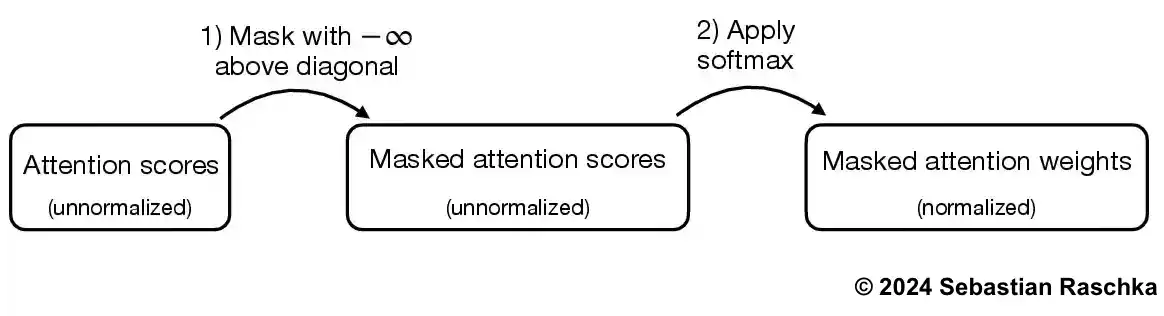

In [31]:
mask = torch.triu(torch.ones(context_length, context_length), diagonal=1)
masked = attn_scores.masked_fill(mask.bool(), -torch.inf)
print(masked)

tensor([[0.3111,   -inf,   -inf,   -inf,   -inf,   -inf],
        [0.1655, 0.2602,   -inf,   -inf,   -inf,   -inf],
        [0.1667, 0.2602, 0.2577,   -inf,   -inf,   -inf],
        [0.0510, 0.1080, 0.1064, 0.0643,   -inf,   -inf],
        [0.1415, 0.1875, 0.1863, 0.0987, 0.1121,   -inf],
        [0.0476, 0.1192, 0.1171, 0.0731, 0.0477, 0.0966]],
       grad_fn=<MaskedFillBackward0>)


* as we can see below, now the attention weights in each row correctly sum to 1 again:

In [32]:
attn_weights = torch.softmax(masked / keys.shape[-1]**0.5, dim=-1)
print(attn_weights)

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.4833, 0.5167, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3190, 0.3408, 0.3402, 0.0000, 0.0000, 0.0000],
        [0.2445, 0.2545, 0.2542, 0.2468, 0.0000, 0.0000],
        [0.1994, 0.2060, 0.2058, 0.1935, 0.1953, 0.0000],
        [0.1624, 0.1709, 0.1706, 0.1654, 0.1625, 0.1682]],
       grad_fn=<SoftmaxBackward0>)


## 3.5.2 Masking additional attention weights with dropout

* in addition, we also apply dropout to reduce overfitting during training

* dropout can be applied in sevral places:
  * for example, after computing the attention weights;
  * of after multiplying the attention weights with the vectors

* here, er will apply thr dropout mask afetr computing the attention weights because its more common

* furthermore, in this specific example, we use a dropout rate of 50% which means randomly masking out half of the attention weights.

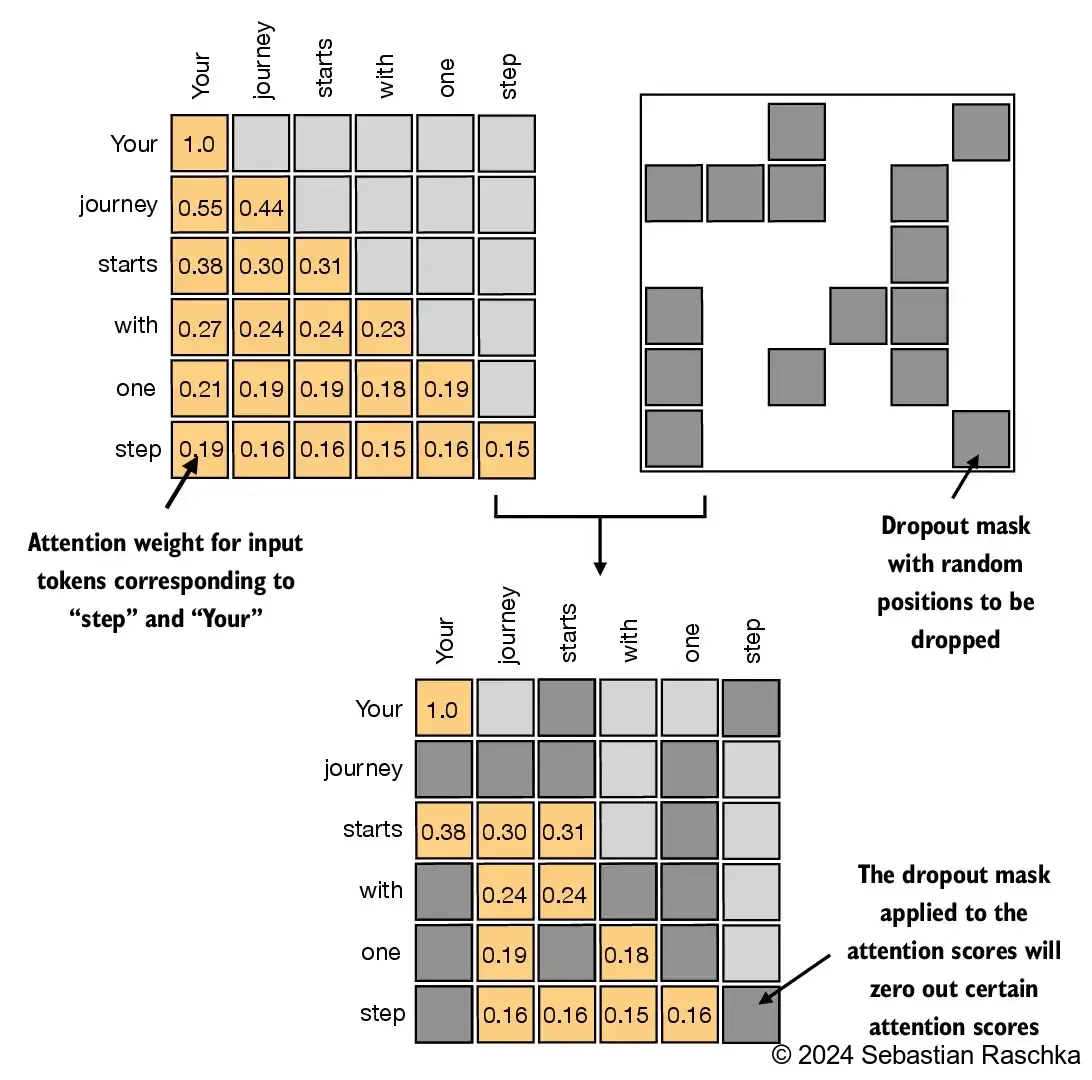

If we apply a dropout rate of 0.5 (50%), the non-dropped values will be scaled accordingly by a factor of 1/0.5 = 2.

In [33]:
torch.manual_seed(123)
dropout = torch.nn.Dropout(0.5)
example = torch.ones(6,6)


print(dropout(example))

tensor([[2., 2., 2., 2., 2., 2.],
        [0., 2., 0., 0., 0., 0.],
        [0., 0., 2., 0., 2., 0.],
        [2., 2., 0., 0., 0., 2.],
        [2., 0., 0., 0., 0., 2.],
        [0., 2., 0., 0., 0., 0.]])


In [34]:
torch.manual_seed(123)
print(dropout(attn_weights))

tensor([[2.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 1.0335, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.0000, 0.6804, 0.0000, 0.0000, 0.0000],
        [0.4889, 0.5090, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3988, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.0000, 0.3418, 0.0000, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)


## 3.5.3 Implementing a compact causal self-attention class



* Now, we are ready to implement a working implementation of self-attention, including the causal and dropout masks

* One more thing is to implement the code to handle batches consisting of more than one input so that our CausalAttention class supports the batch outputs produced by the data loader we implemented in chapter 2

* For simplicity, to simulate such batch input, we duplicate the input text example:
* 

In [35]:
batch = torch.stack((inputs, inputs), dim=0)
print(batch.shape)

torch.Size([2, 6, 3])


In [36]:
batch

tensor([[[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]],

        [[0.4300, 0.1500, 0.8900],
         [0.5500, 0.8700, 0.6600],
         [0.5700, 0.8500, 0.6400],
         [0.2200, 0.5800, 0.3300],
         [0.7700, 0.2500, 0.1000],
         [0.0500, 0.8000, 0.5500]]])

In [37]:
class CausalAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length,dropout, qkv_bias = False):
        super().__init__()
        self.d_out = d_out
        self.w_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.w_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.dropout = nn.Dropout(dropout)
        self.register_buffer('mask', torch.triu(torch.ones(context_length, context_length), diagonal=1))

    def forward(self, x):
        b, num_tokens, d_in = x.shape
        keys = self.w_key(x)
        values = self.w_value(x)
        queries = self.w_query(x)

        attn_scores = queries @ keys.transpose(1,2)
        attn_scores.masked_fill_(
            self.mask.bool()[:num_tokens, :num_tokens], -torch.inf
        )
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        context_vec = attn_weights @ values
        return context_vec
    

torch.manual_seed(123)

context_length = batch.shape[1]
ca = CausalAttention(d_in, d_out, context_length, 0.0)

context_vecs = ca(batch)

print(context_vecs)

tensor([[[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]],

        [[-0.4519,  0.2216],
         [-0.5874,  0.0058],
         [-0.6300, -0.0632],
         [-0.5675, -0.0843],
         [-0.5526, -0.0981],
         [-0.5299, -0.1081]]], grad_fn=<UnsafeViewBackward0>)


## 3.6 Extending single-head attention to multi-head attention

### 3.6.1 Stacking multiple single-head attention layers


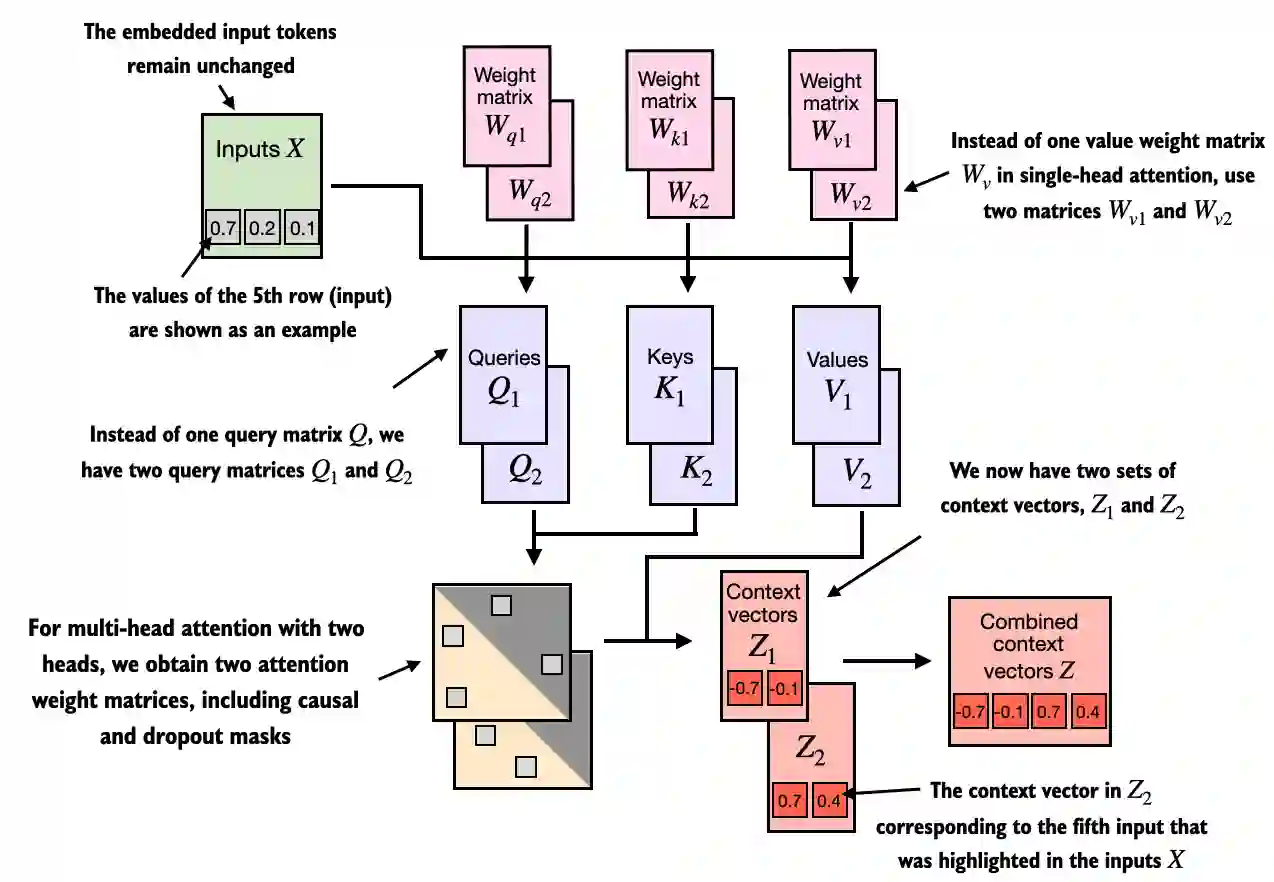

* We simply stack multiple single-head attention modules to obtain a multi-head attention module:


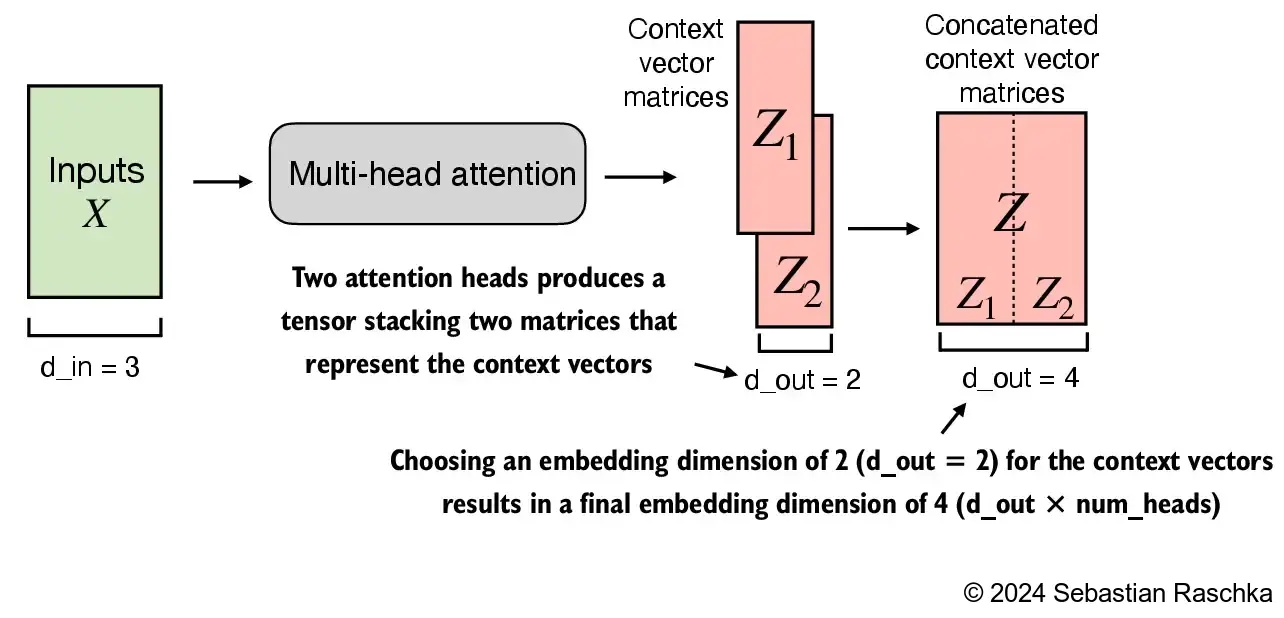

* The main idea behind multi-head attention is to run the attention mechanism multiple times (in parallel) with different, learned linear projections. This allows the model to jointly attend to information from different representation subspaces at different positions.


In [40]:
class MultiheadAttentionWrapper(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_head, qkv_bias= False):
        super().__init__()
        self.heads = nn.ModuleList([CausalAttention(d_in, d_out, context_length, dropout, qkv_bias) for _ in range(num_head)])

    def forward(self, x):
        return torch.cat([head(x) for head in self.heads], dim = -1)
    

torch.manual_seed(123)
context_length = batch.shape[1]
d_in = 3
d_out = 2
mha = MultiheadAttentionWrapper(d_in, d_out, context_length, 0.0, 2)

context_vecs = mha(batch)

print(context_vecs)

tensor([[[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]],

        [[-0.4519,  0.2216,  0.4772,  0.1063],
         [-0.5874,  0.0058,  0.5891,  0.3257],
         [-0.6300, -0.0632,  0.6202,  0.3860],
         [-0.5675, -0.0843,  0.5478,  0.3589],
         [-0.5526, -0.0981,  0.5321,  0.3428],
         [-0.5299, -0.1081,  0.5077,  0.3493]]], grad_fn=<CatBackward0>)


* In the implementation above, the embedding dimension is 4, because we d_out=2 as the embedding dimension for the key, query, and value vectors as well as the context vector. And since we have 2 attention heads, we have the output embedding dimension 2*2=4

## 3.6.2 Implementing multi-head attention with weight splits

* while the above is an intutve and fully functional implementation of multi-head attention, we can write a stand-alone calss called multiheadattention to achieve the same

* we dont conacatenate single attention heads for this stand-alone multiheadattention class

* instead, we create single W_query, w_key, w_value weight matrices and the split those into individual matrices for each attention head:

In [45]:

class MultiHeadAttention(nn.Module):
    def __init__(self, d_in, d_out, context_length, dropout, num_heads, qkv_bias=False):
        super().__init__()
        assert (d_out % num_heads == 0), \
            "d_out must be divisible by num_heads"

        self.d_out = d_out
        self.num_heads = num_heads
        self.head_dim = d_out // num_heads # Reduce the projection dim to match desired output dim

        self.W_query = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_key = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.W_value = nn.Linear(d_in, d_out, bias=qkv_bias)
        self.out_proj = nn.Linear(d_out, d_out)  # Linear layer to combine head outputs
        self.dropout = nn.Dropout(dropout)
        self.register_buffer(
            "mask",
            torch.triu(torch.ones(context_length, context_length),
                       diagonal=1)
        )

    def forward(self, x):
        b, num_tokens, d_in = x.shape

        keys = self.W_key(x) # Shape: (b, num_tokens, d_out)
        queries = self.W_query(x)
        values = self.W_value(x)

        # We implicitly split the matrix by adding a `num_heads` dimension
        # Unroll last dim: (b, num_tokens, d_out) -> (b, num_tokens, num_heads, head_dim)
        keys = keys.view(b, num_tokens, self.num_heads, self.head_dim) 
        values = values.view(b, num_tokens, self.num_heads, self.head_dim)
        queries = queries.view(b, num_tokens, self.num_heads, self.head_dim)

        # Transpose: (b, num_tokens, num_heads, head_dim) -> (b, num_heads, num_tokens, head_dim)
        keys = keys.transpose(1, 2)
        queries = queries.transpose(1, 2)
        values = values.transpose(1, 2)

        # Compute scaled dot-product attention (aka self-attention) with a causal mask
        attn_scores = queries @ keys.transpose(2, 3)  # Dot product for each head

        # Original mask truncated to the number of tokens and converted to boolean
        mask_bool = self.mask.bool()[:num_tokens, :num_tokens]

        # Use the mask to fill attention scores
        attn_scores.masked_fill_(mask_bool, -torch.inf)
        
        attn_weights = torch.softmax(attn_scores / keys.shape[-1]**0.5, dim=-1)
        attn_weights = self.dropout(attn_weights)

        # Shape: (b, num_tokens, num_heads, head_dim)
        context_vec = (attn_weights @ values).transpose(1, 2) 
        
        # Combine heads, where self.d_out = self.num_heads * self.head_dim
        context_vec = context_vec.contiguous().view(b, num_tokens, self.d_out)
        context_vec = self.out_proj(context_vec) # optional projection

        return context_vec

torch.manual_seed(123)

batch_size, context_length, d_in = batch.shape
d_out = 2
mha = MultiHeadAttention(d_in, d_out, context_length, 0.0, num_heads=2)

context_vecs = mha(batch)

print(context_vecs)
print("context_vecs.shape:", context_vecs.shape)

tensor([[[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]],

        [[0.3190, 0.4858],
         [0.2943, 0.3897],
         [0.2856, 0.3593],
         [0.2693, 0.3873],
         [0.2639, 0.3928],
         [0.2575, 0.4028]]], grad_fn=<ViewBackward0>)
context_vecs.shape: torch.Size([2, 6, 2])
